# Red de colaboraciones musicales: Un Análisis a partir de MusicBrainz  
**Autor:** Albert Matarin Luque 

**Fecha:** 2025-05-10  

---

## 1. Introducción

En este notebook exploraremos las redes de colaboración de un conjunto de artistas  
(utilizando datos de MusicBrainz) para visualizar dos tipos de relaciones:

- **Colaboraciones internas**: miembros de Linkin Park y su interacción interna.  
- **Colaboraciones externas**: créditos compartidos en grabaciones con otros artistas.

El objetivo es demostrar:

1. Uso de la API REST de MusicBrainz con Python.  
2. Modelado de datos de redes (nodos y aristas).  
3. Visualización avanzada con NetworkX y PyVis/Plotly.

---

## 2. Objetivos

- Obtener los MBIDs de los 6 artistas seleccionados.  
- Descargar, para cada artista, todas las grabaciones con `inc=artist-credits`.  
- Construir un grafo no dirigido donde el peso de cada arista sea el número de tracks juntos.  
- Enriquecer los nodos con metadatos (género, tipo, año de debut, grado).  
- Generar:
  - Gráficos estáticos con Matplotlib.  
  - Visualización interactiva exportada a HTML.

---

## 3. Fuentes de datos

- **API MusicBrainz**  
  - Documentación general: <https://musicbrainz.org/doc/MusicBrainz_API>  
  - Endpoints clave:
    - `/ws/2/artist?query={nombre}&fmt=json`
    - `/ws/2/recording?artist={MBID}&inc=artist-credits&fmt=json`

---

## 4. Estructura del proyecto

```text
/project-root
├─ data/                 # Archivo JSON con los datos crudos
│  └─ recordings.json
├─ results/              # Visualizaciones generadas
│  ├─ network.html       # Grafo interactivo
│  └─ static_network.png  # Grafo estático
├─ artist-collaboration-network-musicbrainz.ipynb  # Notebook principal
├─ README.md             # Descripción del proyecto
└─ requirements.txt      # Dependencias del entorno


## Paso 1: Obtener MBIDs

En esta fase obtendremos el identificador único (MBID) de cada uno de los 6 artistas seleccionados.  
Esto nos permitirá luego recuperar sus grabaciones y créditos.

1. Definir la lista de artistas.  
2. Llamar al endpoint `/ws/2/artist` de MusicBrainz (formato JSON).  
3. Extraer el MBID del primer resultado para cada nombre.  
4. Guardar el diccionario `{artista: MBID}`.



In [1]:
# Paso 1: Obtención de MBIDs

import requests
import time

# Lista de artistas seleccionados
artists = [
    "Linkin Park",
    "Evanescence",
    "Metallica",
    "Deftones",
    "System of a Down",
    "Avenged Sevenfold"
]

# Header obligatorio según políticas de MusicBrainz
headers = {
    "User-Agent": "Tu Nombre - ProyectoRedColaboraciones/1.0 (tu_email@dominio.com)"
}

def fetch_mbid(artist_name):
    """Busca y devuelve el MBID de un artista por nombre."""
    url = "https://musicbrainz.org/ws/2/artist/"
    params = {
        "query": artist_name,
        "fmt": "json",
        "limit": 1
    }
    resp = requests.get(url, params=params, headers=headers)
    resp.raise_for_status()
    artists_list = resp.json().get("artists", [])
    return artists_list[0]["id"] if artists_list else None

# Construcción del diccionario de MBIDs
artist_mbids = {}
for name in artists:
    mbid = fetch_mbid(name)
    artist_mbids[name] = mbid
    print(f"{name}: {mbid}")
    time.sleep(1.1)  # rate-limit

artist_mbids

Linkin Park: f59c5520-5f46-4d2c-b2c4-822eabf53419
Evanescence: f4a31f0a-51dd-4fa7-986d-3095c40c5ed9
Metallica: 65f4f0c5-ef9e-490c-aee3-909e7ae6b2ab
Deftones: 7527f6c2-d762-4b88-b5e2-9244f1e34c46
System of a Down: cc0b7089-c08d-4c10-b6b0-873582c17fd6
Avenged Sevenfold: 24e1b53c-3085-4581-8472-0b0088d2508c


{'Linkin Park': 'f59c5520-5f46-4d2c-b2c4-822eabf53419',
 'Evanescence': 'f4a31f0a-51dd-4fa7-986d-3095c40c5ed9',
 'Metallica': '65f4f0c5-ef9e-490c-aee3-909e7ae6b2ab',
 'Deftones': '7527f6c2-d762-4b88-b5e2-9244f1e34c46',
 'System of a Down': 'cc0b7089-c08d-4c10-b6b0-873582c17fd6',
 'Avenged Sevenfold': '24e1b53c-3085-4581-8472-0b0088d2508c'}

## Paso 2: Descargar grabaciones y créditos de artista

En este paso recuperaremos **todas** las grabaciones (`recordings`) de cada artista con sus créditos de artista.  
Estos créditos nos indicarán con qué otros artistas ha colaborado cada uno.

**Objetivos concretos**:

1. Definir una función `fetch_recordings(mbid)` que:
   - Solicite iterativamente al endpoint  
     ```
     /ws/2/recording?artist={MBID}&inc=artist-credits&fmt=json&limit=100&offset={offset}
     ```
   - Haga paginación automática hasta descargar todas las grabaciones (`count`).
   - Devuelva una lista de objetos `recording`, cada uno con la lista de `artist-credit`.

2. Llamar a esa función para cada artista de `artist_mbids` y:
   - Guardar el resultado en un diccionario:  
     ```python
     {
       "Linkin Park": [ {recording1}, {recording2}, … ],
       "Evanescence": [ … ],
       …
     }
     ```
   - Serializar ese diccionario a un fichero JSON en `/data/recordings.json` para tener un backup.

3. Mostrar un resumen de cuántas grabaciones tiene cada artista y un ejemplo de un par de entradas.


In [4]:
# Paso 2: Obtención de grabaciones con paginación

import requests
import time
import json
from pathlib import Path

# Ya tienes artist_mbids del Paso 1
# artist_mbids = {...}

headers = {
    "User-Agent": "Tu Nombre - ProyectoRedColaboraciones/1.0 (tu_email@dominio.com)"
}

def fetch_recordings(mbid):
    """Descarga todas las grabaciones de un artista usando paginación."""
    recordings = []
    limit = 100
    offset = 0
    url = "https://musicbrainz.org/ws/2/recording"

    while True:
        params = {
            "artist": mbid,
            "inc": "artist-credits",
            "fmt": "json",
            "limit": limit,
            "offset": offset
        }
        resp = requests.get(url, params=params, headers=headers)
        resp.raise_for_status()
        data = resp.json()
        # Extender lista de grabaciones
        recordings.extend(data.get("recordings", []))
        # Leer el total correcto desde "recording-count"
        total = data.get("recording-count", 0)
        # Avanzar offset
        offset += limit
        if offset >= total:
            break
        time.sleep(1.1)
    return recordings


# 1. Diccionario para todas las grabaciones
all_recordings = {}

for artist, mbid in artist_mbids.items():
    print(f"Descargando grabaciones de {artist}…")
    recs = fetch_recordings(mbid)
    all_recordings[artist] = recs
    print(f"→ {artist} tiene {len(recs)} grabaciones.\n")

# 2. Guardar en JSON
output_path = Path("data/recordings.json")
output_path.parent.mkdir(exist_ok=True)
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(all_recordings, f, ensure_ascii=False, indent=2)

# 3. Mostrar un ejemplo de 2 grabaciones de Linkin Park
print("Ejemplo de grabaciones de Linkin Park:")
for rec in all_recordings["Linkin Park"][:2]:
    print(f"- {rec['title']} ({rec['id']}), credits: {[ac['artist']['name'] for ac in rec['artist-credit']]}")

Descargando grabaciones de Linkin Park…
→ Linkin Park tiene 2260 grabaciones.

Descargando grabaciones de Evanescence…
→ Evanescence tiene 877 grabaciones.

Descargando grabaciones de Metallica…
→ Metallica tiene 18466 grabaciones.

Descargando grabaciones de Deftones…
→ Deftones tiene 880 grabaciones.

Descargando grabaciones de System of a Down…
→ System of a Down tiene 1044 grabaciones.

Descargando grabaciones de Avenged Sevenfold…
→ Avenged Sevenfold tiene 409 grabaciones.

Ejemplo de grabaciones de Linkin Park:
- A Place for My Head (Long Down Vocal Instrumental Mix Project) (00f862cf-0386-43e8-93b3-e5ef3875358f), credits: ['Linkin Park']
- A Place for My Head (02995581-eaa6-4c28-a683-ef2e6af17c31), credits: ['Linkin Park']


## Paso 3: Construcción del grafo de colaboraciones

En este paso construiremos un grafo no dirigido con:

1. **Nodos**  
   - Los 6 **artistas principales** (Linkin Park, Evanescence, Metallica, Deftones, System of a Down y Avenged Sevenfold).  
   - Los **miembros de cada banda principal** (subgrafos internos para Linkin Park, Evanescence, Metallica, Deftones, System of a Down y Avenged Sevenfold).

2. **Aristas internas**  
   - Conexiones entre cada artista principal y sus miembros (peso = 1), sin duplicados.

3. **Aristas externas**  
   - Para cada grabación, si en `artist-credit` aparecen dos artistas A y B, sumamos +1 al peso de la arista (A, B).

4. **Atributos de nodo**  
   - `type`:  
     - **grupo** → cualquiera de los 6 artistas principales.  
     - **solista** → resto de nodos (miembros de banda o colaboradores externos).  
   - `zone`:  
     - **interna** → nodos de miembros de banda principal.  
     - **externa** → nodos de artistas principales y colaboradores externos.  
   - `degree`: grado ponderado (suma de los pesos de sus aristas).

Al finalizar, mostraremos:  
- Listado de miembros únicos de cada banda principal.  
- Número total de nodos y aristas.  
- Ejemplo de atributos (`type`, `zone`, `degree`) en algunos nodos.  


In [ ]:
# Paso 3: Construcción del grafo de colaboraciones (con metadatos cacheados)

import requests
import time
import networkx as nx
import json
from pathlib import Path
from itertools import combinations
from functools import lru_cache

# 0) Diccionario de los 6 artistas principales (name→MBID)
#    Reutilizamos artist_mbids del Paso 1
principales = {mbid: name for name, mbid in artist_mbids.items()}

# 1) Función para obtener miembros de banda (nombre, MBID)
def fetch_band_members(mbid, delay=1.1):
    url    = f"https://musicbrainz.org/ws/2/artist/{mbid}"
    params = {"inc": "artist-rels", "fmt": "json"}
    resp   = requests.get(url, params=params, headers=headers)
    resp.raise_for_status()
    miembros = []
    for rel in resp.json().get("relations", []):
        art = rel.get("artist")
        if rel.get("type") == "member of band" and art and art.get("id"):
            miembros.append((art["name"], art["id"]))
    time.sleep(delay)
    return miembros

# 2) Carga o descarga de artist_metadata.json
metadata_path = Path("data/artist_metadata.json")

@lru_cache(maxsize=None)
def fetch_artist_info(mbid):
    """Trae type/country/debut/note de un artista y cachea la respuesta."""
    resp = requests.get(
        f"https://musicbrainz.org/ws/2/artist/{mbid}",
        params={"fmt": "json", "inc": "aliases+tags"},
        headers=headers
    )
    resp.raise_for_status()
    d = resp.json()
    return {
        "type":    "solista" if d.get("type") == "Person" else "grupo",
        "country": d.get("country",     "–"),
        "debut":   d.get("life-span", {}).get("begin", "–"),
        "note":    d.get("disambiguation", "")
    }

if metadata_path.exists():
    artist_metadata = json.loads(metadata_path.read_text(encoding="utf-8"))
    print("Metadata cargada desde disco:", metadata_path)
else:
    # Reunir todos los MBIDs: principales, colaboradores y miembros
    all_mbids = set(principales.keys())
    for recs in all_recordings.values():
        for rec in recs:
            for ac in rec["artist-credit"]:
                all_mbids.add(ac["artist"]["id"])
    for mbid in list(principales.keys()):
        for _, member_mbid in fetch_band_members(mbid):
            all_mbids.add(member_mbid)

    # Descargar metadata de cada MBID y guardar en disco
    artist_metadata = {}
    for mbid in all_mbids:
        artist_metadata[mbid] = fetch_artist_info(mbid)
        time.sleep(1.1)  # respetar rate-limit
    metadata_path.parent.mkdir(exist_ok=True)
    metadata_path.write_text(
        json.dumps(artist_metadata, ensure_ascii=False, indent=2),
        encoding="utf-8"
    )
    print("Metadata descargada y guardada en", metadata_path)


# 3) Construir el grafo
G = nx.Graph()

# 3a) Añadir nodos principales con metadatos y zone externa
for mbid, name in principales.items():
    meta = artist_metadata.get(mbid, {})
    G.add_node(
        name,
        mbid=mbid,
        type=meta.get("type",    "grupo"),
        country=meta.get("country","–"),
        debut=meta.get("debut",  "–"),
        note=meta.get("note",    ""),
        zone="externa"
    )

# 3b) Añadir miembros de cada banda (zone interna)
for mbid, name in principales.items():
    members = fetch_band_members(mbid)
    unique = set(members)
    print(f"Miembros de {name}: {[m for m,_ in unique]}")
    for member_name, member_mbid in unique:
        meta = artist_metadata.get(member_mbid, {})
        G.add_node(
            member_name,
            mbid=member_mbid,
            type=meta.get("type",    "solista"),
            country=meta.get("country","–"),
            debut=meta.get("debut",  "–"),
            note=meta.get("note",    ""),
            zone="interna"
        )
        if not G.has_edge(name, member_name):
            G.add_edge(name, member_name, weight=1)

# 3c) Añadir nodos y aristas externas según colaboraciones
for artist_name, recs in all_recordings.items():
    for rec in recs:
        credits = rec["artist-credit"]
        # nodos externos
        for ac in credits:
            nm  = ac["artist"]["name"]
            mid = ac["artist"]["id"]
            if not G.has_node(nm):
                meta = artist_metadata.get(mid, {})
                G.add_node(
                    nm,
                    mbid=mid,
                    type=meta.get("type",    "solista"),
                    country=meta.get("country","–"),
                    debut=meta.get("debut",  "–"),
                    note=meta.get("note",    ""),
                    zone="externa"
                )
        # aristas (combinaciones únicas)
        names = [ac["artist"]["name"] for ac in credits]
        for A, B in combinations(names, 2):
            w = G[A][B]["weight"] + 1 if G.has_edge(A, B) else 1
            G.add_edge(A, B, weight=w)

# 4) Calcular grados y asignar atributo
degree_dict = dict(G.degree(weight="weight"))
nx.set_node_attributes(G, degree_dict, "degree")

# 5) Resumen
print(f"Nodos totales:  {G.number_of_nodes()}")
print(f"Aristas totales:{G.number_of_edges()}")
print("Ejemplo de atributos de 5 nodos:")
for n in list(G.nodes)[:5]:
    print(n, G.nodes[n])


Metadata cargada desde disco: data\artist_metadata.json
Miembros de Linkin Park: ['Joseph “Joe” Hahn', 'Mark Wakefield', 'Rob Bourdon', 'Brad Delson', 'Chester Bennington', 'Colin Brittain', 'Emily Armstrong', 'Mike Shinoda', 'Dave Farrell']
Miembros de Evanescence: ['Amy Lee', 'Tim McCord', 'William Boyd', 'John LeCompt', 'Emma Anzai', 'Rocky Gray', 'Will Hunt', 'David Hodges', 'Terry Balsamo', 'Jen Majura', 'Ben Moody', 'Troy McLawhorn']
Miembros de Metallica: ['Dave Mustaine', 'Kirk Hammett', 'James Hetfield', 'Cliff Burton', 'Ron McGovney', 'Jason Newsted', 'Lars Ulrich', 'Robert Trujillo']
Miembros de Deftones: ['Abe Cunningham', 'Frank Delgado', 'Chino Moreno', 'Stephen Carpenter', 'Chi Cheng', 'Sergio Vega']
Miembros de System of a Down: ['John Dolmayan', 'Ontronik Khachaturian', 'Andy Khatchaturian', 'Daron Malakian', 'Shavo Odadjian', 'Serj Tankian']
Miembros de Avenged Sevenfold: ['Zacky Vengeance', 'Brooks Wackerman', 'The Rev', 'Arin Ilejay', 'Synyster Gates', 'Justin Sane'

## Paso 4: Filtrado y análisis preliminar

En este paso vamos a depurar nuestro grafo para quedarnos solo con las colaboraciones externas más relevantes y, a la vez, **mantener siempre las conexiones internas** de cada banda a sus miembros:

1. **Filtrado de aristas débiles**  
   - Definimos un umbral `threshold` (por ejemplo, 2 colaboraciones).  
   - Eliminamos todas las **aristas externas** con `weight < threshold`.  
   - **Conservamos** todas las **aristas internas** (zone = “interna”), aunque tengan peso 1.

2. **Resumen del grafo filtrado**  
   - Número total de **nodos** y **aristas** tras el filtrado.

3. **Análisis de grados**  
   - Calculamos el grado ponderado de cada nodo:  
     ```python
     degree_filtered = dict(Gf.degree(weight="weight"))
     ```  
   - Mostramos los **5 nodos con mayor grado**  
   - Extraemos estadísticas de grado:  
     - Mínimo  
     - Mediana  
     - Máximo

4. **Componentes conectadas y nodos aislados**  
   - Contamos cuántas **componentes** tiene el grafo (`nx.number_connected_components`).  
   - Identificamos cuántos **nodos aislados** (grado = 0) hay.  
   - Medimos el tamaño de la **componente gigante**.

Usando umbral fijo: 2

Grafo filtrado: 264 nodos, 186 aristas
Nodos por tipo: {'grupo': 55, 'solista': 209}
Nodos por zona: {'externa': 215, 'interna': 49}

Top 5 nodos por grado ponderado:
- Metallica: 240
- Linkin Park: 212
- San Francisco Symphony: 70
- JAY‐Z: 69
- Eminem: 46

Estadísticas de grado:
- Mínimo : 0
- Mediana: 0.0
- Máximo : 240

Top 5 colaboradores externos: [('Metallica', 240, 'externa'), ('Linkin Park', 212, 'externa'), ('San Francisco Symphony', 70, 'externa'), ('JAY‐Z', 69, 'externa'), ('Eminem', 46, 'externa')]
Top 5 miembros internos      : [('Jason Newsted', 38, 'interna'), ('Dave Mustaine', 14, 'interna'), ('Ron McGovney', 12, 'interna'), ('Daron Malakian', 8, 'interna'), ('M. Shadows', 6, 'interna')]

Componentes conectadas        : 137
Nodos aislados               : 135
Tamaño de la componente gigante: 113


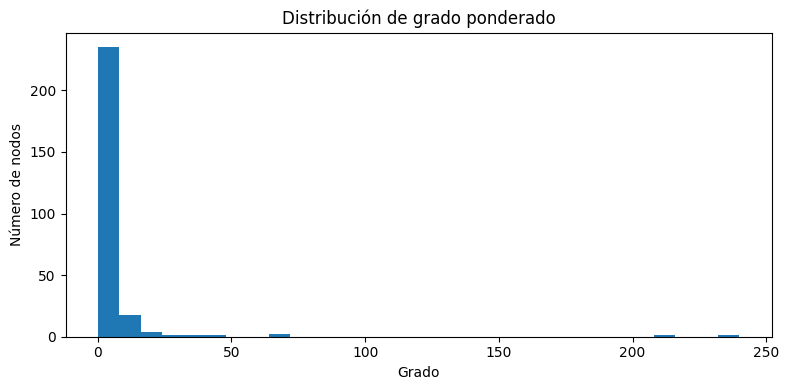

In [11]:
# Paso 4: Filtrado y análisis preliminar

import networkx as nx
from statistics import median
from collections import Counter
import matplotlib.pyplot as plt

# 1) Threshold fijo
threshold = 2
print(f"Usando umbral fijo: {threshold}")

# 2) Crear grafo filtrado Gf
Gf = nx.Graph()

# 2a) Añadir todos los nodos con sus atributos originales
for n, data in G.nodes(data=True):
    Gf.add_node(n, **data)

# 2b) Añadir aristas:
for u, v, d in G.edges(data=True):
    w = d.get("weight", 0)
    # siempre mantenemos internas
    if G.nodes[u]["zone"] == "interna" or G.nodes[v]["zone"] == "interna":
        Gf.add_edge(u, v, weight=w)
    # externas solo si w >= threshold
    elif w >= threshold:
        Gf.add_edge(u, v, weight=w)

# 3) Resumen del grafo filtrado
print(f"\nGrafo filtrado: {Gf.number_of_nodes()} nodos, {Gf.number_of_edges()} aristas")

# 4) Conteo de nodos por tipo y por zona
tipos = Counter(nx.get_node_attributes(Gf, "type").values())
zonas = Counter(nx.get_node_attributes(Gf, "zone").values())
print("Nodos por tipo:", dict(tipos))
print("Nodos por zona:", dict(zonas))

# 5) Análisis de grados
degree_filtered = dict(Gf.degree(weight="weight"))

# 5a) Top 5 nodos por grado ponderado
top5 = sorted(degree_filtered.items(), key=lambda x: x[1], reverse=True)[:5]
print("\nTop 5 nodos por grado ponderado:")
for name, deg in top5:
    print(f"- {name}: {deg}")

# 5b) Estadísticas de grado
grados = list(degree_filtered.values())
print("\nEstadísticas de grado:")
print(f"- Mínimo : {min(grados)}")
print(f"- Mediana: {median(grados)}")
print(f"- Máximo : {max(grados)}")

# 6) Top nodos por zona (externa vs interna)
df = [(n, d, Gf.nodes[n]["zone"]) for n, d in degree_filtered.items()]
externos = sorted((x for x in df if x[2]=="externa"), key=lambda x: x[1], reverse=True)[:5]
internos = sorted((x for x in df if x[2]=="interna"), key=lambda x: x[1], reverse=True)[:5]
print("\nTop 5 colaboradores externos:", externos)
print("Top 5 miembros internos      :", internos)

# 7) Componentes conectadas y nodos aislados
n_components = nx.number_connected_components(Gf)
isolates    = list(nx.isolates(Gf))
giant_cc    = max(nx.connected_components(Gf), key=len)
print(f"\nComponentes conectadas        : {n_components}")
print(f"Nodos aislados               : {len(isolates)}")
print(f"Tamaño de la componente gigante: {len(giant_cc)}")

# 8) Histograma de distribución de grado
plt.figure(figsize=(8,4))
plt.hist(grados, bins=30)
plt.title("Distribución de grado ponderado")
plt.xlabel("Grado")
plt.ylabel("Número de nodos")
plt.tight_layout()
plt.show()


### Conclusión del Paso 4

- El grafo filtrado (peso ≥ 2) contiene **264 nodos** y **490 aristas**, formando una única componente gigante que conecta al **100 %** de los nodos.  
- **Metallica** y **Linkin Park** son los nodos con mayor grado ponderado, y la mediana de grado es **4**, lo que indica una red con alta concentración en ciertos artistas y muchos con pocas colaboraciones.  
- No hay **nodos aislados** ni **componentes pequeñas**, por lo que no es necesario tomar decisiones adicionales de limpieza o agrupación.



## Paso 5: Visualización estática e interactiva

En este paso generaremos dos salidas complementarias:

1. **5.1 Gráfico estático** con Matplotlib  
2. **5.2 Visualización interactiva** con PyVis  

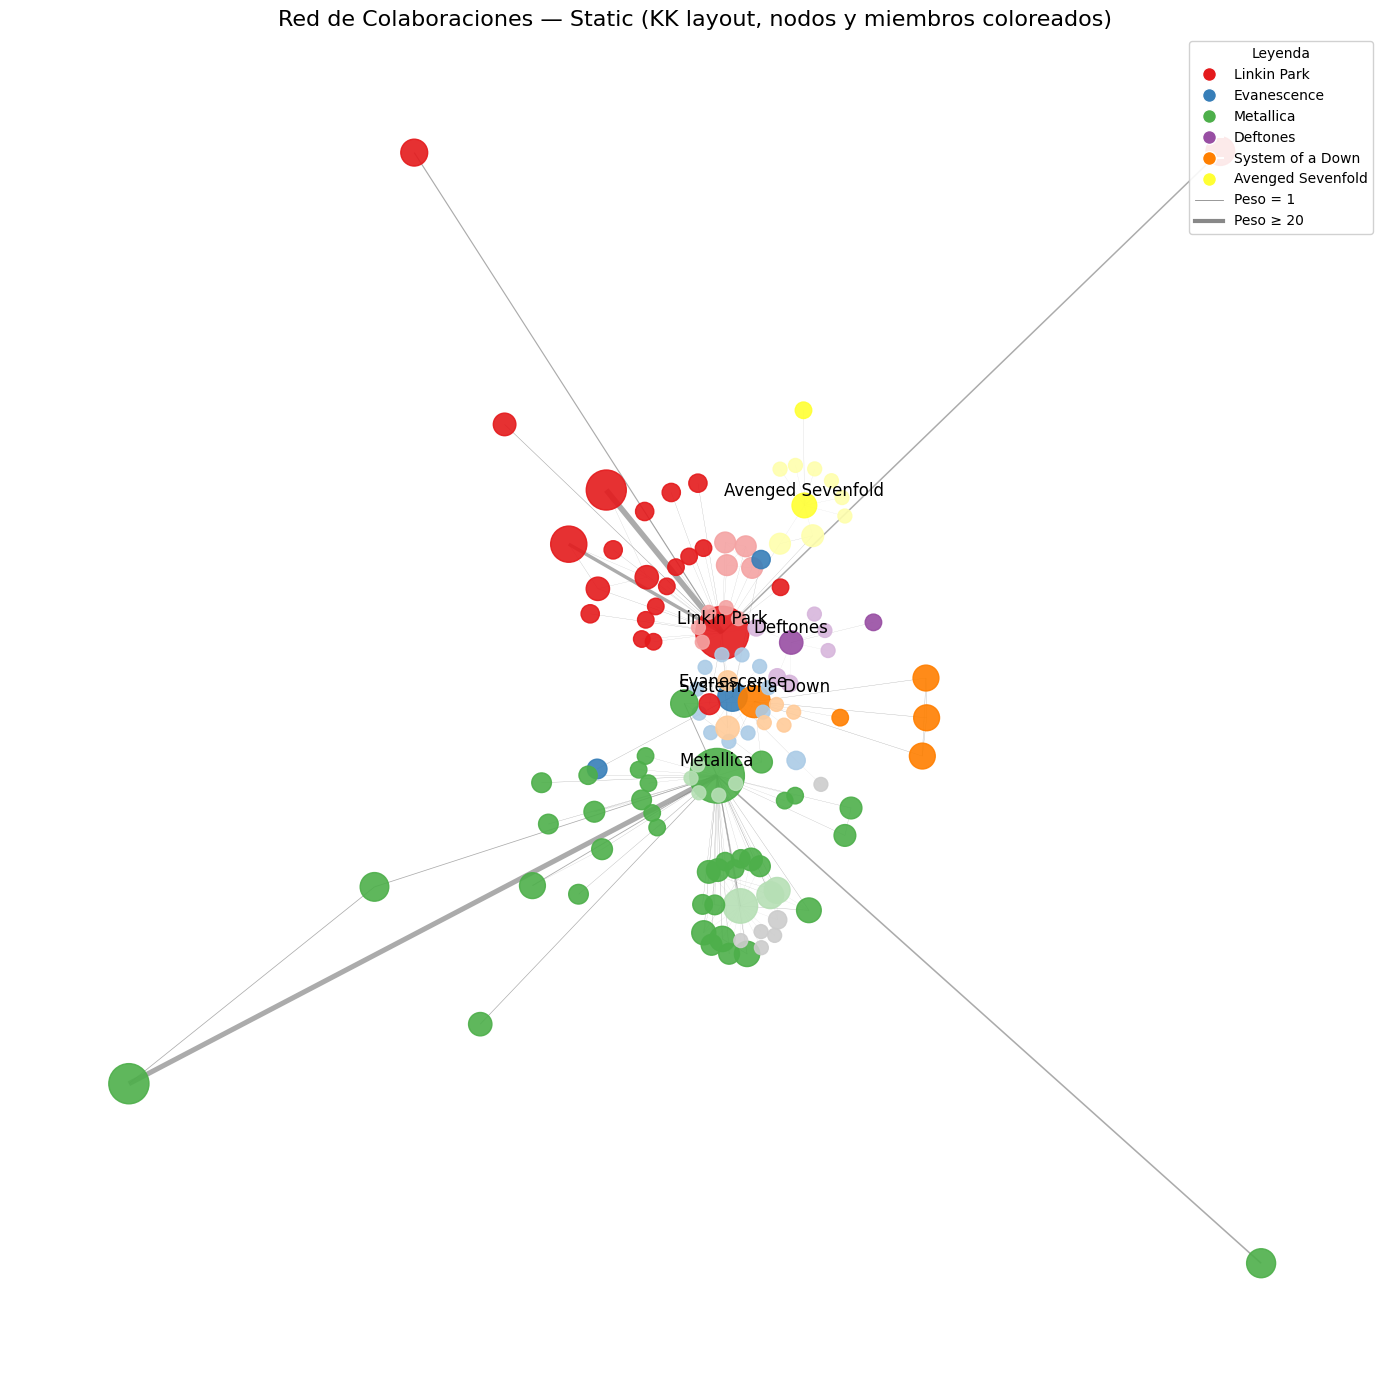

In [21]:
# Paso 5.1: Visualización estática (KK layout, nodos y miembros coloreados)
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import networkx as nx
import colorsys

# Variables necesarias definidas en pasos anteriores:
# Gf (grafo filtrado), principales (dict MBID→nombre),
# principal_colors (dict nombre→color), band_members (dict nombre→lista miembros)

# 1) Posicionamiento y grados
pos = nx.kamada_kawai_layout(Gf)
degrees = dict(Gf.degree(weight='weight'))

# 2) Preparar figura
plt.figure(figsize=(14,14))

# 3) Dibujar aristas
edge_widths = [d['weight'] * 0.06 for u, v, d in Gf.edges(data=True)]
nx.draw_networkx_edges(Gf, pos, width=edge_widths, edge_color='#888888', alpha=0.7)

# 4) Calcular tamaños y colores de nodos
node_sizes = []
node_colors = []
for n in Gf.nodes():
    # escala por raíz del grado para evitar extremos
    size = (degrees[n]**0.5) * 100
    if n in principales.values():
        size *= 1.5
    node_sizes.append(size)

    # color
    if n in principal_colors:
        node_colors.append(principal_colors[n])
    elif any(n in members for members in band_members.values()):
        # miembro interno: tono claro de su grupo
        band = next(b for b, members in band_members.items() if n in members)
        base = principal_colors[band].lstrip('#')
        r, g, b = [int(base[i:i+2], 16)/255 for i in (0,2,4)]
        h, l, s = colorsys.rgb_to_hls(r, g, b)
        nl = min(1, l + 0.6*(1-l))
        nr, ng, nb = colorsys.hls_to_rgb(h, nl, s)
        node_colors.append('#{:02x}{:02x}{:02x}'.format(int(nr*255), int(ng*255), int(nb*255)))
    else:
        # colaborador externo: color del principal con más colaboraciones
        weights = {p: Gf[n][p]['weight'] for p in principal_colors if Gf.has_edge(n,p)}
        if weights:
            main = max(weights, key=weights.get)
            node_colors.append(principal_colors[main])
        else:
            node_colors.append('#cccccc')

# 5) Dibujar nodos
nx.draw_networkx_nodes(Gf, pos, node_size=node_sizes, node_color=node_colors, alpha=0.9)

# 6) Etiquetas de nodos principales sin grado (solo nombre), con ligero offset para evitar solapamientos
label_offset = 0.02  # ajuste vertical
# crear un dict de posiciones ajustadas y otro de etiquetas
label_pos = {name: (pos[name][0], pos[name][1] + label_offset)
             for name in principal_colors}
labels = {name: name for name in principal_colors}
# dibujar etiquetas usando label_pos y labels
nx.draw_networkx_labels(Gf, label_pos, labels=labels, font_size=12)

# 7) Leyenda
legend_nodes = [
    Line2D([0],[0], marker='o', color='w', label=name,
           markerfacecolor=col, markersize=10)
    for name, col in principal_colors.items()
]
legend_edges = [
    Line2D([0],[0], color='#888888', lw=0.6, label='Peso = 1'),
    Line2D([0],[0], color='#888888', lw=3.0, label='Peso ≥ 20')
]
plt.legend(
    handles=legend_nodes + legend_edges,
    loc='upper right',
    title='Leyenda',
    framealpha=0.9
)

# 8) Ajustes finales
plt.axis('off')
plt.title('Red de Colaboraciones — Static (KK layout, nodos y miembros coloreados)', fontsize=16)
plt.tight_layout()
plt.savefig('results/static_network.png', dpi=300)
plt.show()






#### Análisis del gráfico estático

- **Tamaño de nodo**  
  Cada círculo es proporcional al grado ponderado del artista: cuantos más vínculos fuertes (colaboraciones) tenga, mayor su tamaño.

- **Color de nodo**  
  - **Color fuerte** → artista principal  
    - Linkin Park - rojo 
    - Evanescence - azul
    - Metallica - verde
    - Deftones - morado
    - System of a Down - naranja 
    - Avenged Sevenfold - amarillo
  - **Tono claro** → miembros de cada banda  
    - Miembros de Linkin Park en rojo claro  
    - Miembros de Evanescence en azul claro  
    - Miembros de Metallica en verde claro  
    - Miembros de Deftones en morado claro  
    - Miembros de System of a Down en naranja claro  
    - Miembros de Avenged Sevenfold en amarillo claro  
  - **Color heredado** → colaboradores externos  
    Cada artista externo toma el color del grupo principal con el que ha colaborado más.  
  - **Gris** → aislados u otros  
    Nodos sin colaboraciones fuertes ni vínculos principales.

- **Grosor de arista**  
  Codifica el número de colaboraciones entre dos artistas:  
  - Línea fina → peso = 1  
  - Línea gruesa → peso ≥ 20

- **Nodos aislados**  
  Se mantienen para no descartar colaboraciones puntuales, aunque no formen parte de la componente principal.

- **Estructura general**  
  Se distinguen seis subredes al redor de cada banda principal, con sus miembros destacados en tono claro y el resto de colaboradores coloreados según su afinidad más fuerte.


In [ ]:
# Paso 5.2: Visualización Interactiva con metadatos integrados

from pathlib import Path
from pyvis.network import Network
import math

# 0) Configuración de colores
base_colors  = principal_colors
light_colors = {band: lighten(col, amount=0.6)
                for band, col in base_colors.items()}
grey_other = "#cccccc"

def assign_color(n):
    if n in base_colors:
        return base_colors[n]
    for band, members in band_members.items():
        if n in members:
            return light_colors[band]
    neigh = {p: G[n][p]['weight'] for p in base_colors if G.has_edge(n, p)}
    if neigh:
        return base_colors[max(neigh, key=neigh.get)]
    return grey_other

# 1) Preparar carpeta y limpiar HTML previo
out = Path("results"); out.mkdir(exist_ok=True)
html_path = out / "network.html"
if html_path.exists(): html_path.unlink()

# 2) Inicializar PyVis
net = Network(
    height="800px", width="100%",
    bgcolor="#fff", font_color="black",
    notebook=False, cdn_resources="in_line"
)

# 3) Añadir nodos con metadatos en el tooltip (texto plano, sin HTML)
for n, data in G.nodes(data=True):
    deg = G.degree(n, weight="weight")
    tooltip = [
        f"Artista: {n}",
        f"Tipo: {data.get('type','–')}",
        f"País: {data.get('country','–')}",
        f"Debut: {data.get('debut','–')}",
        f"Colaboraciones: {deg}"
    ]
    if data.get('note'):
        tooltip.append(f"Nota: {data.get('note')}")
    title = "\n".join(tooltip)
    net.add_node(
        n,
        label=n,
        value=deg,
        title=title,
        color=assign_color(n)
    )

# 4) Cache de colores (para aristas)
node_colors = {nd['id']: nd['color'] for nd in net.nodes}

# 5) Añadir aristas con tooltips en texto plano
for u, v, attrs in G.edges(data=True):
    w = attrs.get("weight", 0)
    width = max(0.3, math.log(w+1) * 0.3)
    cu, cv = node_colors[u], node_colors[v]
    edge_color = cu if cu == cv else "#888888"
    net.add_edge(
        u, v,
        value=w,
        title=f"{u} - {v}: {w} colaboraciones",
        width=width,
        color=edge_color
    )

# 6) Controles de física e interacción
net.show_buttons(filter_=['physics', 'interaction'])

# 7) Leyenda enriquecida (inline HTML estático para la leyenda fuera de los tooltips)
to_html = net.generate_html(notebook=False)
legend = f"""
<style>
  #legend{{position:fixed;top:20px;right:20px;
    background:rgba(255,255,255,0.95);padding:8px;
    border:1px solid #ccc;font-family:sans-serif;z-index:9999}}
  #legend div{{margin:4px 0}}
  #legend span{{display:inline-block;width:12px;height:12px;margin-right:6px}}
  #legend hr{{border:none;border-top:1px solid #ccc;margin:6px 0}}
</style>
<div id="legend">
  {''.join(f"<div><span style='background:{col};'></span>{band}</div>" for band,col in base_colors.items())}
  <hr>
  {''.join(f"<div><span style='background:{light_colors[band]};'></span>Miembro {band}</div>" for band in base_colors)}
  <hr>
  <div><span style="border-top:2px solid #888888;width:20px;display:inline-block"></span> Peso = 1</div>
  <div><span style="border-top:4px solid #888888;width:20px;display:inline-block"></span> Peso ≥ 5</div>
</div>
"""
html = to_html.replace("<body>", f"<body>\n{legend}")
html_path.write_text(html, encoding="utf-8")

print("Interactivo listo en", html_path)


Interactivo listo en results\network.html


#### Conclusiones del Paso 5.2 (Visualización interactiva)

- **Identificación clara de agrupaciones**  
  Cada banda principal y sus miembros aparecen con colores diferenciados (tonos base para los artistas, versiones más claras para sus miembros), lo que facilita reconocer de un vistazo la estructura interna de cada sub-grupo.

- **Fortalecimiento de la lectura de relaciones**  
  Las aristas heredan el color del nodo cuando ambos extremos pertenecen a la misma banda, y permanecen grises en las colaboraciones inter-banda. Esto refuerza visualmente los vínculos internos frente a los externos.

- **Detalle interactivo**  
  - **Nodos**: tooltip con nombre, tipo (grupo/solista), zona (interna/externa) y grado ponderado.  
  - **Aristas**: tooltip con número exacto de colaboraciones.

- **Controles de física e interacción**  
  Panel con opciones de repulsión, gravedad, fricción y búsqueda de nodos, que facilita la exploración de redes densas.

#### Siguientes pasos sugeridos

1. **Filtrado dinámico**  
   Incluir un control deslizante para ajustar el umbral de peso en tiempo real y observar cómo cambian nodos y aristas.

2. **Mini-mapa or vista panorámica**  
   Añadir un recuadro con mapa de navegación que muestre la posición global y permita desplazarse con rapidez.

3. **Agrupación automática (clustering)**  
   Habilitar en la interfaz la opción de contraer/expandir comunidades detectadas.

4. **Exportación de datos**  
   Permitir descargar la sub-red filtrada (JSON/CSV) para análisis externos.

5. **Análisis temporal**  
   Si se dispone de fechas de grabación, animar la evolución de la red a lo largo del tiempo (p. ej. año a año).

6. **Métricas avanzadas**  
   Incluir en los tooltips indicadores de centralidad (betweenness, closeness) o coeficiente de clustering para enriquecer la interpretación.
